In [4]:
from rdkit import Chem
import numpy as np
import sys
sys.path.append('../')
sys.path.append('../data_processing/')

from openbabel import pybel
import matplotlib
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
import torch

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from data_processing.ligand import Ligand
from data_processing.utils import sample_probability

In [7]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, Image
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.ipython_useSVG = True
IPythonConsole.molSize = 600, 300

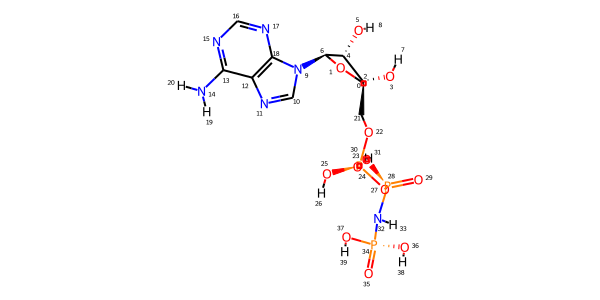

In [8]:
path = '../../data/small_dataset/raw/ZAP70_HUMAN_327_607_0/2ozo_A_rec_2ozo_anp_lig_tt_docked_2.sdf'
rdmol = Chem.MolFromMolFile(path, sanitize=False)
rdmol

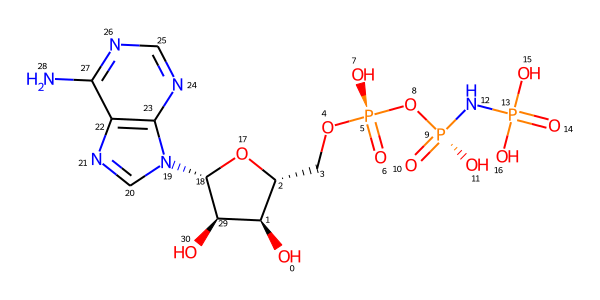

In [9]:
mol = Chem.MolFromSmiles(Chem.MolToSmiles(rdmol))
mol

- atomic number becomes different -> don't use this mol to show pp/cluster

In [10]:
len(rdmol.GetConformers())

1

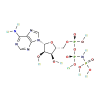

In [11]:
pbmol = next(pybel.readfile("sdf", path))
pbmol

In [12]:
ligand = Ligand(pbmol, rdmol, atom_positions=None, conformer_axis=None)
len(ligand.graph.node_clusters)

5

In [13]:
n_atom = 0
n = 0
for cluster in ligand.graph.node_clusters:
    print(len(cluster.nodes))
    n += cluster.positions.shape[1]
    for node in cluster.nodes:
        atom_idx = node.atom_indices
        print(atom_idx)
        n_atom += len(atom_idx)
print('total number of atoms involved in at least one cluster:', n_atom)  # there are overlappings
print('total number of pp nodes in all clusters:', n)

1
{12, 13, 15, 16, 17, 18}
1
{22, 23, 24, 25, 27}
2
{37}
{35}
1
{5}
1
{14}
total number of atoms involved in at least one cluster: 15
total number of pp nodes in all clusters: 6


- Overlapping problem: some atoms exist in multiple pp/clusters

In [14]:
atom_indice_list = []

for node in ligand.graph.nodes:
    print(node.positions.squeeze())
    print(node.types, node.index)
    atom_indices = list([node.atom_indices]) if type(node.atom_indices)==int else list(sorted(node.atom_indices))
    print(atom_indices)
    atom_indice_list.append(atom_indices)
    
atom_indice_list

[ 22.611116 -13.793384 -10.184682]
['Aromatic'] 0
[12, 13, 15, 16, 17, 18]
[ 27.9741 -19.2302 -10.8439]
['Anion'] 1
[22, 23, 24, 25, 27]
[ 27.3684 -22.5473 -10.1264]
['HBond_donor'] 2
[37]
[ 27.9357 -12.9032  -9.1948]
['HBond_donor'] 3
[5]
[ 20.608  -15.7476  -9.8918]
['HBond_donor'] 4
[14]
[ 28.4022 -24.2515  -8.4428]
['HBond_acceptor'] 5
[35]


[[12, 13, 15, 16, 17, 18], [22, 23, 24, 25, 27], [37], [5], [14], [35]]

In [65]:
torch.tensor(atom_indice_list)

ValueError: expected sequence of length 6 at dim 1 (got 1)

In [58]:
ligand.atom_positions.squeeze().shape

(25, 3)

In [59]:
ligand.num_atoms

25

In [60]:
# direct get positions from conformer will include Hs
conformer = rdmol.GetConformer()
conformer.GetPositions().shape

(25, 3)

In [61]:
all_pp = []
for i, (pp_type, pp_node) in enumerate(ligand.pharmacophore_list):
    atom_indices = tuple([pp_node.atom_indices]) if type(pp_node.atom_indices)==int else tuple(sorted(pp_node.atom_indices))
#     print(pp_type, atom_indices)
    all_pp.append([pp_type, atom_indices, i])
    

all_pp

[['Aromatic', (0, 1, 2, 6, 8, 9), 0],
 ['Hydrophobic', (15,), 1],
 ['Hydrophobic', (14,), 2],
 ['Hydrophobic', (13,), 3],
 ['HBond_donor', (7,), 4],
 ['HBond_donor', (20,), 5]]

In [49]:
def remove_overlapping_pp(pp_list):
    # Sort clusters by size in descending order
    pp_list.sort(key=lambda x:len(x[1]), reverse=True)

    unique_nodes = set()
    non_overlapping_pp = []

    for pp in pp_list:
        # If cluster nodes are not in unique_nodes, add them
        if not any(node in unique_nodes for node in pp[1]):
            unique_nodes.update(pp[1])
            non_overlapping_pp.append(pp)

    return non_overlapping_pp

In [50]:
pp_list = remove_overlapping_pp(all_pp)
pp_list

[['Aromatic', (0, 1, 2, 6, 8, 9), 6],
 ['Hydrophobic', (13,), 0],
 ['Hydrophobic', (14,), 1],
 ['Hydrophobic', (15,), 2],
 ['Hydrophobic', (16,), 3],
 ['Hydrophobic', (22,), 4],
 ['Hydrophobic', (24,), 5],
 ['HBond_donor', (7,), 9],
 ['HBond_donor', (17,), 10],
 ['HBond_donor', (20,), 11],
 ['HBond_acceptor', (3,), 13]]

In [34]:
one_hot_encoding = {'H': 0, 'C': 1, 'N': 2, 'O': 3, 'F': 4, 'P': 5, 'S': 6, 'Cl': 7}    # 8 classes
one_hot_x = [one_hot_encoding[atom.GetSymbol()] for atom in rdmol.GetAtoms()]
one_hot_x

[1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 3, 1, 0, 2, 0, 1, 1, 1]

In [37]:
one_hot_x_tensor = torch.tensor(one_hot_x, dtype=torch.long)
one_hot_x_tensor = torch.nn.functional.one_hot(one_hot_x_tensor, num_classes=len(one_hot_encoding.keys())).to(torch.float)
one_hot_x_tensor

tensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0

In [56]:
random.seed(2024)
random.shuffle(all_pp)
num = [3, 4, 5, 6, 7]
num_p = [0.086, 0.0864, 0.389, 0.495, 0.0273]  # P(Number of Pharmacophore points)
num_ = sample_probability(num, num_p, 1)
num_

[5]

In [39]:
type_list = []
size_ = []

## The randomly generated clusters are obtained,
# and the next step is to perform a preliminary merging of these randomly generated clusters with identical elements
if len(all_pp) >= int(num_[0]):
    mol_phco = all_pp[:int(num_[0])]
else:
    mol_phco = all_pp

for pharmocophore_all_i in range(len(mol_phco)):
    for pharmocophore_all_j in range(len(mol_phco)):
        if mol_phco[pharmocophore_all_i][1] == mol_phco[pharmocophore_all_j][1] \
                and mol_phco[pharmocophore_all_i][0] != mol_phco[pharmocophore_all_j][0]:
            index_ = [min(mol_phco[pharmocophore_all_i][0], mol_phco[pharmocophore_all_j][0]),
                      max(mol_phco[pharmocophore_all_i][0], mol_phco[pharmocophore_all_j][0])]
            mol_phco[pharmocophore_all_j] = [index_, mol_phco[pharmocophore_all_i][1], mol_phco[pharmocophore_all_i][2]]
            mol_phco[pharmocophore_all_i] = [index_, mol_phco[pharmocophore_all_i][1], mol_phco[pharmocophore_all_i][2]]
        else:
            index_ = mol_phco[pharmocophore_all_i][0]

In [40]:
mol_phco

[['Aromatic', (0, 2, 3, 4, 5), 7],
 ['HBond_acceptor', (3,), 13],
 ['Hydrophobic', (13,), 2],
 ['Hydrophobic', (18,), 4],
 ['Hydrophobic', (14,), 3],
 ['Hydrophobic', (12,), 1]]

In [41]:
unique_index_filter = []
unique_index = []
for mol_phco_candidate_single in mol_phco:
    if mol_phco_candidate_single not in unique_index:
        if type(mol_phco[0]) == list:
            unique_index.append(mol_phco_candidate_single)
        else:
            unique_index.append([[mol_phco_candidate_single[0]], mol_phco_candidate_single[1]], mol_phco[pharmocophore_all_i][2])
for unique_index_single in unique_index:
    if unique_index_single not in unique_index_filter:
        unique_index_filter.append(unique_index_single)

In [42]:
unique_index_filter

[['Aromatic', (0, 2, 3, 4, 5), 7],
 ['HBond_acceptor', (3,), 13],
 ['Hydrophobic', (13,), 2],
 ['Hydrophobic', (18,), 4],
 ['Hydrophobic', (14,), 3],
 ['Hydrophobic', (12,), 1]]

In [43]:
## The following is the order of the pharmacophores by atomic number
sort_index_list = []
for unique_index_filter_i in unique_index_filter:  ## Collect the mean of the participating elements
    sort_index = sum(unique_index_filter_i[1]) / len(unique_index_filter_i[1])
    sort_index_list.append(sort_index)
sorted_id = sorted(range(len(sort_index_list)), key=lambda k: sort_index_list[k])
unique_index_filter_sort = []
for index_id in sorted_id:
    unique_index_filter_sort.append(unique_index_filter[index_id])

In [44]:
unique_index_filter_sort

[['Aromatic', (0, 2, 3, 4, 5), 7],
 ['HBond_acceptor', (3,), 13],
 ['Hydrophobic', (12,), 1],
 ['Hydrophobic', (13,), 2],
 ['Hydrophobic', (14,), 3],
 ['Hydrophobic', (18,), 4]]

In [46]:
new_pp_list = []
for item in unique_index_filter_sort:
    idx = item[2]
    new_pp_list.append(ligand.pharmacophore_list[idx])
new_pp_list

[('Aromatic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee5780>),
 ('HBond_acceptor',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee8190>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635beea320>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee8280>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635beea290>),
 ('Hydrophobic',
  <data_processing.ligand_utils.PharmacophoreNode at 0x7f635bee82e0>)]

In [52]:
def group_by(mol, ligand, level='pp'):
    my_cmap = matplotlib.colormaps['coolwarm']
#     my_cmap = cm.get_cmap('coolwarm')
    if level == 'cluster':
        n_group = len(ligand.graph.node_clusters)
    elif level == 'pp':
        n = 0
        for cluster in ligand.graph.node_clusters:
            n += cluster.positions.shape[1]
        n_group = n
        pp_id = 0
        
    my_norm = Normalize(vmin=0, vmax=n_group)
    atommap, bondmap = {}, {}
    for i in range(len(ligand.graph.node_clusters)):
        cluster = ligand.graph.node_clusters[i]
        for node in cluster.nodes:
#             node = cluster.nodes[pp_id]
            atom_idx = node.atom_indices
            if level == 'cluster':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(i))
                atommap.update({atom_id:my_cmap(my_norm(i))[:3] for atom_id in atom_idx})
            elif level == 'pp':
                for atom_id in atom_idx:
                    atom = mol.GetAtoms()[atom_id]
                    atom.SetProp("atomNote", str(pp_id))
                atommap.update({atom_id:my_cmap(my_norm(pp_id))[:3] for atom_id in atom_idx})
                pp_id += 1
                
    highlights = {
        "highlightAtoms": list(atommap.keys()),
        "highlightAtomColors": atommap,
        "highlightBonds": list(bondmap.keys()),
        "highlightBondColors": bondmap,
    }
    mol_ = rdMolDraw2D.PrepareMolForDrawing(mol)
    imgsize = (600, 300)
    drawer = rdMolDraw2D.MolDraw2DSVG(*imgsize)
    drawer.DrawMolecule(mol_, **highlights)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))

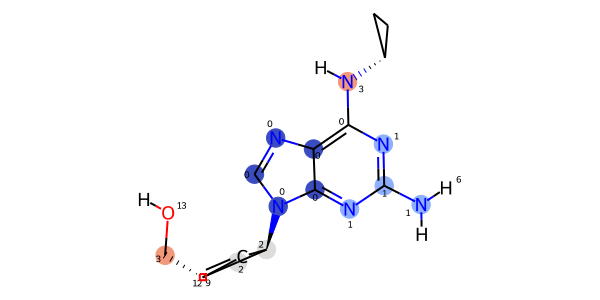

In [53]:
group_by(rdmol, ligand, 'cluster')

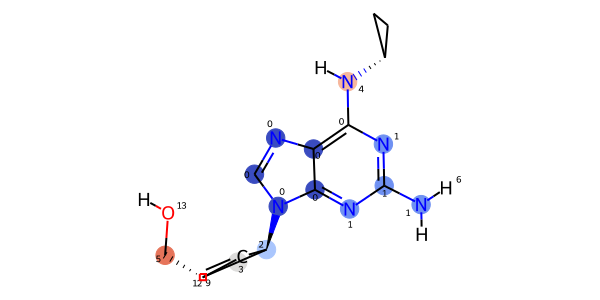

In [54]:
group_by(rdmol, ligand, 'pp')